In [1]:
import cowsay

cowsay.fox('Glad you made it this far. This is the final, and core calculation for the whole model. We used logistic regression and linear regression for alternative route to replace the very optimal solution -- Beta Regression. Use preset formula to calculate Expected Loss. And from the final table, the bank can make further adjustment on policies and limitations for its users.')

  _________________________________________________
 /                                                 \
| Glad you made it this far. This is the final, and |
|  core calculation for the whole model. We used lo |
| gistic regression and linear regression for alter |
| native route to replace the very optimal solution |
|  -- Beta Regression. Use preset formula to calcul |
| ate Expected Loss. And from the final table, the  |
| bank can make further adjustment on policies and  |
| limitations for its users.                        |
 \                                                 /
                                                  \
                                                   \
                                                    \
                                                     |\_/|,,_____,~~`
                                                     (.".)~~     )`~}}
                                                      \o/\ /---~\\ ~}}
                                       

# Part 4:  LGD and EAD Models, And Expected Loss

# Import Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy.stats as stat

from sklearn import linear_model
import scipy.stats as stat
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score

import warnings 
warnings.filterwarnings('ignore')

# Import Data

In [3]:
loan_data_preprocessed_backup = pd.read_csv('loan_data_2007_2014_preprocessed.csv')

loan_data_preprocessed = loan_data_preprocessed_backup.copy()
loan_data_preprocessed

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,0,0,0,0,0,0,0,1,0,1
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,0,0,0,0,0,1,0,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,0,0,0,0,0,1,0,1
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,0,0,0,0,0,1,0,1
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,466280,8598660,1440975,18400,18400,18400.0,60 months,14.47,432.64,C,...,0,0,0,0,0,0,0,0,1,1
466281,466281,9684700,11536848,22000,22000,22000.0,60 months,19.97,582.50,D,...,0,0,0,0,0,0,0,1,0,0
466282,466282,9584776,11436914,20700,20700,20700.0,60 months,16.99,514.34,D,...,0,0,0,0,0,0,0,1,0,1
466283,466283,9604874,11457002,2000,2000,2000.0,36 months,7.90,62.59,A,...,0,0,0,0,0,0,0,0,1,1


In [4]:
# build models based on data from borrowers that have had enough time to repay part of their remaining debt.

# In this dataset, it means 'does not meet credit policy' or 'charged off' in the [loan status] column.

loan_data_defaults = loan_data_preprocessed[loan_data_preprocessed['loan_status'].isin(['Charged Off',
                                                                                       'Does not meet the credit policy. Status:Charged Off'])]


In [5]:
pd.options.display.max_rows = None
loan_data_defaults.isnull().sum()

# The independent variables in LGD and EAD models do not have to be only dummy variables, like in the PD model.

# mths_since_last_delinq & mths_since_last_record  can be considered continuous variables.

Unnamed: 0                                                             0
id                                                                     0
member_id                                                              0
loan_amnt                                                              0
funded_amnt                                                            0
funded_amnt_inv                                                        0
term                                                                   0
int_rate                                                               0
installment                                                            0
grade                                                                  0
sub_grade                                                              0
emp_title                                                           3287
emp_length                                                          2337
home_ownership                                     

In [6]:
# We are going to use only one dataset to store the data needed for both.


################################### Independent Variables


loan_data_defaults['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_defaults['mths_since_last_record'].fillna(0, inplace = True)


################################### Dependent Variables

# ----------->>>>> LGD dependent 

# LGD = 1 - recovery rate
# Recovery rate = recoveries / funded amount
loan_data_defaults['recovery_rate'] = loan_data_defaults['recoveries'] / loan_data_defaults['funded_amnt']
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] > 1, 1, loan_data_defaults['recovery_rate'])
loan_data_defaults['recovery_rate'] = np.where(loan_data_defaults['recovery_rate'] < 0, 0, loan_data_defaults['recovery_rate'])

# ----------->>>>> EAD dependent 

# Total exposure at default contribute to Credit Conversion Factor
loan_data_defaults['CCF'] = (loan_data_defaults['funded_amnt'] - loan_data_defaults['total_rec_prncp']) / loan_data_defaults['funded_amnt']



In [7]:
# Save default data to CSV for backup.

loan_data_defaults.to_csv('loan_data_defaults.csv')

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

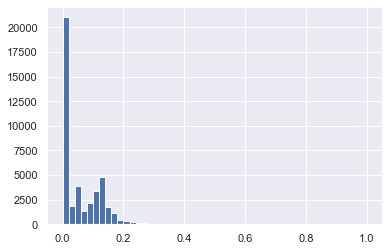

In [8]:
# Explore dependent variables.

plt.hist(loan_data_defaults['recovery_rate'], bins = 50)

(array([   3.,   17.,   16.,   44.,   16.,   13.,   71.,   26.,    7.,
          63.,   67.,   17.,   60.,   90.,   23.,   55.,   82.,   42.,
          47.,  123.,   82.,   70.,  122.,   86.,   89.,  110.,  117.,
         111.,  122.,  120.,  135.,  141.,  154.,  146.,  160.,  175.,
         152.,  187.,  202.,  174.,  204.,  208.,  210.,  211.,  241.,
         264.,  281.,  224.,  308.,  267.,  287.,  296.,  340.,  274.,
         365.,  370.,  392.,  364.,  393.,  419.,  411.,  429.,  445.,
         497.,  481.,  478.,  569.,  568.,  599.,  618.,  727.,  691.,
         626.,  805.,  804.,  776.,  881.,  851.,  916.,  934.,  925.,
        1078.,  933., 1218., 1041., 1082., 1336., 1040., 1374., 1073.,
        1406., 1287.,  952., 1414.,  795., 1320.,  578.,  949.,  343.,
         531.]),
 array([4.3800000e-04, 1.0433620e-02, 2.0429240e-02, 3.0424860e-02,
        4.0420480e-02, 5.0416100e-02, 6.0411720e-02, 7.0407340e-02,
        8.0402960e-02, 9.0398580e-02, 1.0039420e-01, 1.1038982e-01

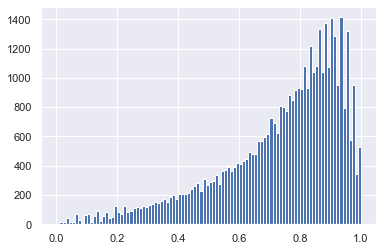

In [9]:
plt.hist(loan_data_defaults['CCF'], bins = 100)

Methodologically speaking, the density of proportions is best described as a specific distribution, called:

Beta Distribution.



The regression model used to assess the impact of a set of independent variables on a variable with beta distribution is called:

Beta Regression.

R-studio has package designed for Beta Regression that can be suitable for this case.

For python, we can only seek an alternative solution on this one: meaning we use similar and reasonable different models to continue.

In [11]:
# Two-stage approach:

############## 1) is recovery rate equal to 0 or greater than 0? ------------------------->>> use Logistic Regression
############## 2) if recovery rate is greater than 0, how much exactly is it? -------------->>> use Linear Regression

# For CCF - Credit Conversion Factors we will use a multiple linear regression model.

# Data preparation
loan_data_defaults['recovery_rate_0_1'] = np.where(loan_data_defaults['recovery_rate'] == 0, 0, 1)
loan_data_defaults['recovery_rate_0_1'].head()

1     1
8     1
9     1
12    1
14    1
Name: recovery_rate_0_1, dtype: int32

# LGD Model

#### Splitting Data

In [12]:
# Split into train test model

lgd_inputs_stage_1_train, lgd_inputs_stage_1_test, lgd_targets_stage_1_train, lgd_targets_stage_1_test = train_test_split(loan_data_defaults.drop(['good_bad','recovery_rate','recovery_rate_0_1','CCF'], axis = 1), loan_data_defaults['recovery_rate_0_1'], test_size = 0.2, random_state = 42)

#### Preparing the Inputs

In [13]:
features_all = [
    'grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    'home_ownership:MORTGAGE',
    'home_ownership:NONE',
    'home_ownership:OTHER',
    'home_ownership:OWN',
    'home_ownership:RENT',
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    'purpose:car',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:educational',
    'purpose:home_improvement',
    'purpose:house',
    'purpose:major_purchase',
    'purpose:medical',
    'purpose:moving',
    'purpose:other',
    'purpose:renewable_energy',
    'purpose:small_business',
    'purpose:vacation',
    'purpose:wedding',
    'initial_list_status:f',
    'initial_list_status:w',
    'term_int',
    'emp_length_int',
    'mnths_since_issue_d',
    'mnths_since_earliest_cr_line',
    'funded_amnt',
    'int_rate',
    'installment',
    'annual_inc',
    'dti',
    'delinq_2yrs',
    'inq_last_6mths',
    'mths_since_last_delinq',
    'mths_since_last_record',
    'open_acc',
    'pub_rec',
    'total_acc',
    'acc_now_delinq',
    'total_rev_hi_lim'
]

In [14]:
# then defined reference categories:

features_reference_cat = [
    'grade:G',
    'home_ownership:RENT',
    'verification_status:Verified',
    'purpose:credit_card',
    'initial_list_status:f'
]

In [15]:
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train[features_all]
lgd_inputs_stage_1_train = lgd_inputs_stage_1_train.drop(features_reference_cat, axis = 1) # drop reference category


## Estimating the Model

### Stage 1 --->>> Logistic Regression

Stage 1 -->>

Is recovery rate greater than 0?

If No, then Recovery Rate = 0.
If Yes, predict Estimated recovery rate 

Stage 2 -- >>

Predict Estimated Recovery Rate

In [16]:
class LogisticRegression_with_p_values:
    
    def __init__(self,*args,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)

    def fit(self,X,y):
        self.model.fit(X,y)
        
        denom = (2.0 * (1.0 + np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X / denom).T,X)
        Cramer_Rao = np.linalg.inv(F_ij)
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0] / sigma_estimates
        p_values = [stat.norm.sf(abs(x)) * 2 for x in z_scores] 
        
        self.coef_ = self.model.coef_
        self.intercept_ = self.model.intercept_
        self.p_values = p_values

In [17]:
reg_lgd_st_1 = LogisticRegression_with_p_values()

reg_lgd_st_1.fit(lgd_inputs_stage_1_train, lgd_targets_stage_1_train)

# Estimates the coefficients of the object from the 'LogisticRegression' class
# with inputs (independent variables) contained in the first dataframe
# and targets (dependent variables) contained in the second dataframe.

In [18]:
feature_name = lgd_inputs_stage_1_train.columns.values

In [19]:
# Create Summary Table to contain coef and p_values

summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_1.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_1.intercept_[0]]
summary_table = summary_table.sort_index()

p_values = reg_lgd_st_1.p_values
p_values = np.append(np.nan,np.array(p_values))
# add the value 'NaN' in the beginning of the variable with p-values.
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,-2.333325e-04,NaN
1,grade:A,-2.834871e-05,9.997344e-01
2,grade:B,-1.474516e-04,9.982893e-01
3,grade:C,-2.642097e-04,9.968208e-01
4,grade:D,2.413025e-05,9.997210e-01
5,grade:E,2.356612e-05,9.997529e-01
6,grade:F,1.368254e-04,9.987511e-01
7,home_ownership:MORTGAGE,-6.665403e-05,9.979132e-01
8,home_ownership:NONE,1.657062e-06,9.999983e-01
9,home_ownership:OTHER,5.240894e-07,9.999990e-01


E notation means 10 power of n

#### Testing the model

In [20]:
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test[features_all]
lgd_inputs_stage_1_test = lgd_inputs_stage_1_test.drop(features_reference_cat, axis = 1)

In [21]:
# model predict method -->> get a rough prediction on the results

y_hat_test_lgd_stage_1 = reg_lgd_st_1.model.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_1

array([1, 1, 0, ..., 1, 1, 0])

In [22]:
y_hat_test_proba_lgd_stage_1 = reg_lgd_st_1.model.predict_proba(lgd_inputs_stage_1_test)
y_hat_test_proba_lgd_stage_1
#   (1 - recovery rate) |  Recovery rate

array([[0.41434964, 0.58565036],
       [0.3758039 , 0.6241961 ],
       [0.51366823, 0.48633177],
       ...,
       [0.4182339 , 0.5817661 ],
       [0.42153174, 0.57846826],
       [0.52142895, 0.47857105]])

In [23]:
y_hat_test_proba_lgd_stage_1 = y_hat_test_proba_lgd_stage_1[: ][: , 1]
# Here we take all the arrays in the array, and from each array, we take all rows, and only the element with index 1,
# that is, the second element.
# In other words, we take only the probabilities for being 1.

In [24]:
y_hat_test_proba_lgd_stage_1 # now we can compare them with the actual values, or to say, the test targets.

array([0.58565036, 0.6241961 , 0.48633177, ..., 0.5817661 , 0.57846826,
       0.47857105])

Estimate Accuracy now -->> below

In [25]:
# create a temporary df just in case.

lgd_targets_stage_1_test_temp = lgd_targets_stage_1_test
lgd_targets_stage_1_test_temp.reset_index(drop = True, inplace = True)

In [26]:
df_actual_predicted_probs = pd.concat([lgd_targets_stage_1_test_temp, pd.DataFrame(y_hat_test_proba_lgd_stage_1)], axis = 1)

In [27]:
df_actual_predicted_probs.columns = ['lgd_targets_stage_1_test', 'y_hat_test_proba_lgd_stage_1']

In [28]:
df_actual_predicted_probs.index = lgd_inputs_stage_1_test.index

df_actual_predicted_probs.head()

,lgd_targets_stage_1_test,y_hat_test_proba_lgd_stage_1
178928,1,0.585650
69814,1,0.624196
101396,0,0.486332
463268,1,0.550580
253729,0,0.407448


#### Estimating the Accuracy of the Model

In [29]:
tr = 0.5

# If results greater than 1, make it 1.
df_actual_predicted_probs['y_hat_test_lgd_stage_1'] = np.where(df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'] > tr, 1, 0)

In [30]:
# build confusion matrix -->> using crosstab.

pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted'])

Predicted,0,1
Actual,,
0,1283,2479
1,877,4009


In [31]:
# separated accuracy:
pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]


Predicted,0,1
Actual,,
0,0.148358,0.286656
1,0.101411,0.463575


In [32]:
# Overall accuracy:

(pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[0, 0] + (pd.crosstab(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_lgd_stage_1'], rownames = ['Actual'], colnames = ['Predicted']) / df_actual_predicted_probs.shape[0]).iloc[1, 1]
# sum of the diagonal rates.

# Ehhh....0.612 is not that great.

0.6119333950046253

Text(0.5, 1.0, 'ROC curve')

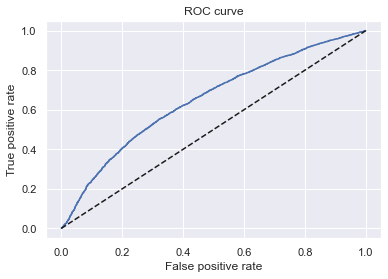

In [33]:
# Use ROC curve again to calcualte the area under the line.

fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])


plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate') # "False positive rate".
plt.ylabel('True positive rate') #  "True positive rate".
plt.title('ROC curve')

In [34]:
# Area under the curve:

AUROC = roc_auc_score(df_actual_predicted_probs['lgd_targets_stage_1_test'], df_actual_predicted_probs['y_hat_test_proba_lgd_stage_1'])
# Calculates the Area Under the Receiver Operating Characteristic Curve (AUROC)
# from a set of actual values and their predicted probabilities.
AUROC

0.6507193354576857

0.65 is fine, but not a great value we wanted.

It is more important to have a large proportion of correctly classified values that are greater than 0, than to have correctly classified 0s.

#### Saving the Model

In [35]:
# pickle -->> convert python object into character string.

# 1. save 'regression_lgd_Stage_1' variabel into a file
# 2. Load the file into a new notebook to reuse the model

import pickle

In [36]:
pickle.dump(reg_lgd_st_1, open('lgd_model_stage_1.sav', 'wb')) # (file name, write bytes)
# dump means save.

## Stage 2  --->>> Linear Regression

In [37]:
lgd_stage_2_data = loan_data_defaults[loan_data_defaults['recovery_rate_0_1'] == 1]

In [38]:
lgd_inputs_stage_2_train, lgd_inputs_stage_2_test, lgd_targets_stage_2_train, lgd_targets_stage_2_test = train_test_split(lgd_stage_2_data.drop(['good_bad', 'recovery_rate', 'recovery_rate_0_1', 'CCF'], axis = 1), lgd_stage_2_data['recovery_rate'], test_size = 0.2, random_state = 42)

In [39]:
class LinearRegression(linear_model.LinearRegression):
    def __init__(self, fit_intercept=True, normalize=False, copy_X=True,
                 n_jobs=1):
        super().__init__(fit_intercept=fit_intercept, normalize=normalize, copy_X=copy_X, n_jobs=n_jobs)
        self.fit_intercept = fit_intercept
        self.normalize = normalize
        self.copy_X = copy_X
        self.n_jobs = n_jobs    
    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
        self.t = self.coef_ / se
        self.p = np.squeeze(2 * (1 - stat.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1])))
        return self

In [40]:
# select only the variables we need.

lgd_inputs_stage_2_train = lgd_inputs_stage_2_train[features_all]
lgd_inputs_stage_2_train = lgd_inputs_stage_2_train.drop(features_reference_cat, axis = 1)

In [41]:
reg_lgd_st_2 = LinearRegression()
reg_lgd_st_2.fit(lgd_inputs_stage_2_train, lgd_targets_stage_2_train)

LinearRegression()

In [42]:
feature_name = lgd_inputs_stage_2_train.columns.values

In [43]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_lgd_st_2.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_lgd_st_2.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_lgd_st_2.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values.round(3)
summary_table

,Feature name,Coefficients,p_values
0,Intercept,2.406858e-01,NaN
1,grade:A,-6.826892e-02,0.000
2,grade:B,-5.083556e-02,0.000
3,grade:C,-3.748066e-02,0.000
4,grade:D,-2.717310e-02,0.000
5,grade:E,-1.315941e-02,0.002
6,grade:F,-5.260168e-03,0.275
7,home_ownership:MORTGAGE,2.832212e-03,0.061
8,home_ownership:NONE,1.459035e-01,0.000
9,home_ownership:OTHER,-9.475922e-03,0.644


Now we have a clear graph showing us coefficients of feature name toward every 1% change in interest rates.

## Stage 2 --->>> Linear Regression Evaluation (Continued)

In [44]:
# let's see how well this linear model projects recovery rates that are greater than zero.

lgd_inputs_stage_2_test = lgd_inputs_stage_2_test[features_all]
lgd_inputs_stage_2_test = lgd_inputs_stage_2_test.drop(features_reference_cat, axis = 1)

lgd_inputs_stage_2_test.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'home_ownership:MORTGAGE', 'home_ownership:NONE',
       'home_ownership:OTHER', 'home_ownership:OWN',
       'verification_status:Not Verified',
       'verification_status:Source Verified', 'purpose:car',
       'purpose:debt_consolidation', 'purpose:educational',
       'purpose:home_improvement', 'purpose:house',
       'purpose:major_purchase', 'purpose:medical', 'purpose:moving',
       'purpose:other', 'purpose:renewable_energy',
       'purpose:small_business', 'purpose:vacation', 'purpose:wedding',
       'initial_list_status:w', 'term_int', 'emp_length_int',
       'mnths_since_issue_d', 'mnths_since_earliest_cr_line',
       'funded_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'total_acc',
       'acc_now_delinq', 'total_rev_hi_lim'], dtype=object)

In [45]:
y_hat_test_lgd_stage_2 = reg_lgd_st_2.predict(lgd_inputs_stage_2_test)

In [46]:
# correlation between actual and predicted values

lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test
lgd_targets_stage_2_test_temp = lgd_targets_stage_2_test_temp.reset_index(drop = True)

In [47]:
pd.concat([lgd_targets_stage_2_test_temp, pd.DataFrame(y_hat_test_lgd_stage_2)], axis = 1).corr()

# this is weak~moderate positive correltaion, but satisfactory for an lgd model.
# If corre is too high then we question the methodology

,recovery_rate,0
recovery_rate,1.000000,0.307996
0,0.307996,1.000000


<AxesSubplot:xlabel='recovery_rate', ylabel='Density'>

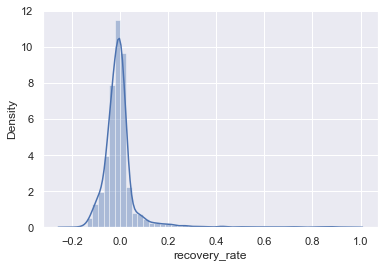

In [48]:
# We need further investigation on the residual values.

sns.distplot(lgd_targets_stage_2_test - y_hat_test_lgd_stage_2)
# This shows near a normal distribution.
# This is a good model! 
# we can dump the model to generate output.

In [49]:
pickle.dump(reg_lgd_st_2, open('lgd_model_stage_2.sav', 'wb'))

## Combining Stage 1 and Stage 2

In [50]:
y_hat_test_lgd_stage_2_all = reg_lgd_st_2.predict(lgd_inputs_stage_1_test)
y_hat_test_lgd_stage_2_all

# This contains all recovery rates that are estimated by the linear regression, 
# no matter if they were predicted by 0 or 1 in stage_1

array([0.1193906 , 0.09605635, 0.13367631, ..., 0.12078611, 0.11587422,
       0.15667447])

In [51]:
# Multiply stage_1 variables with stage_2 (0s and 1s)

y_hat_test_lgd = y_hat_test_lgd_stage_1 * y_hat_test_lgd_stage_2_all

In [52]:
pd.DataFrame(y_hat_test_lgd).describe()
# we see min is < 0. 
# But Natual domain recovery rate is [0,1]

,0
count,8648.000000
mean,0.079002
std,0.051450
min,-0.007634
25%,0.000000
50%,0.095687
75%,0.118403
max,0.236973


In [53]:
# Fix the range to [0,1]

y_hat_test_lgd = np.where(y_hat_test_lgd < 0, 0, y_hat_test_lgd)
y_hat_test_lgd = np.where(y_hat_test_lgd > 1, 1, y_hat_test_lgd)
pd.DataFrame(y_hat_test_lgd).describe()

,0
count,8648.000000
mean,0.079004
std,0.051447
min,0.000000
25%,0.000000
50%,0.095687
75%,0.118403
max,0.236973


Now we are good to go!

# EAD Model

#### Estimation and Interpretation

In [54]:
ead_inputs_train, ead_inputs_test, ead_targets_train, ead_targets_test = train_test_split(loan_data_defaults.drop(['good_bad', 'recovery_rate','recovery_rate_0_1', 'CCF'], axis = 1), loan_data_defaults['CCF'], test_size = 0.2, random_state = 42)
# Takes a set of inputs and a set of targets as arguments. Splits the inputs and the targets into four dataframes:
# Inputs - Train, Inputs - Test, Targets - Train, Targets - Test.

In [55]:
ead_inputs_train = ead_inputs_train[features_all]
ead_inputs_train = ead_inputs_train.drop(features_reference_cat, axis = 1)

In [56]:
reg_ead = LinearRegression()
reg_ead.fit(ead_inputs_train, ead_targets_train)

LinearRegression()

In [57]:
feature_name = ead_inputs_train.columns.values

In [58]:
# Copy Paste the summary table formula from above!

summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg_ead.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg_ead.intercept_]
summary_table = summary_table.sort_index()
p_values = reg_ead.p
p_values = np.append(np.nan,np.array(p_values))
summary_table['p_values'] = p_values
summary_table

,Feature name,Coefficients,p_values
0,Intercept,1.109746e+00,NaN
1,grade:A,-3.030033e-01,0.000000e+00
2,grade:B,-2.364277e-01,0.000000e+00
3,grade:C,-1.720232e-01,0.000000e+00
4,grade:D,-1.198470e-01,0.000000e+00
5,grade:E,-6.768713e-02,0.000000e+00
6,grade:F,-2.045907e-02,4.428795e-03
7,home_ownership:MORTGAGE,-6.343341e-03,2.632464e-03
8,home_ownership:NONE,-5.539064e-03,9.318931e-01
9,home_ownership:OTHER,-2.426052e-03,9.335820e-01


Higher CCF -->> amount of exposure in borrower defaults would be higher.

Positive Coefficients = Increase in CCF (higher risk)

Negative Coefficients = Decrease in CCF (Lower risk)

All that coeffcients are referenced to Reference table:

example: Grade A has -30.30% amount exposure if borrower defaults, comparing to Grad G. Vice Versa


# Model Validation

In [59]:
ead_inputs_test = ead_inputs_test[features_all]
ead_inputs_test = ead_inputs_test.drop(features_reference_cat, axis = 1)

In [60]:
y_hat_test_ead = reg_ead.predict(ead_inputs_test)

In [61]:
# Create temp df again for manipulation
ead_targets_test_temp = ead_targets_test
ead_targets_test_temp = ead_targets_test_temp.reset_index(drop = True)

In [62]:
# calculate corre again, for actual in ead_targets_test and predicted 

pd.concat([ead_targets_test_temp, pd.DataFrame(y_hat_test_ead)], axis =1).corr()

,CCF,0
CCF,1.000000,0.530654
0,0.530654,1.000000


The model has a relatively strong positive correlation.

Good sign.

<AxesSubplot:xlabel='CCF', ylabel='Density'>

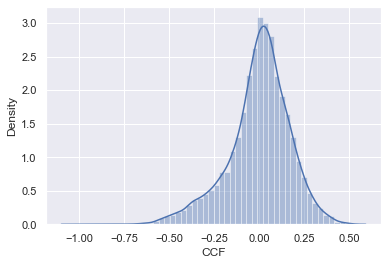

In [63]:
# Check residuals

sns.distplot(ead_targets_test - y_hat_test_ead)

similar to normal distribution. That is good! 

Seems to be a good model methodologically as well.

In [64]:
y_hat_test_ead = np.where(y_hat_test_ead > 1, 1, y_hat_test_ead)
y_hat_test_ead = np.where(y_hat_test_ead < 0, 0, y_hat_test_ead)
# make sure those max and mins are in [0,1]


pd.DataFrame(y_hat_test_ead).describe()

,0
count,8648.000000
mean,0.735992
std,0.105127
min,0.384774
25%,0.661553
50%,0.731750
75%,0.810625
max,1.000000


# Expected Loss


The Final step.

#### LGD

In [65]:
# total expected loss simply is the sum()
# load preprocessed data first

loan_data_preprocessed.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,addr_state:UT,addr_state:VA,addr_state:VT,addr_state:WA,addr_state:WI,addr_state:WV,addr_state:WY,initial_list_status:f,initial_list_status:w,good_bad
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,0,0,0,0,0,0,0,1,0,1
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,0,0,0,0,0,1,0,0
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,0,0,0,0,0,1,0,1
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,0,0,0,0,0,1,0,1
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,0,0,0,0,0,1,0,1


In [66]:
loan_data_preprocessed['mths_since_last_delinq'].fillna(0, inplace = True)
loan_data_preprocessed['mths_since_last_record'].fillna(0, inplace = True)

In [67]:
# best to have separate dfs to save LGD and EAD models.


loan_data_preprocessed_lgd_ead = loan_data_preprocessed[features_all]
loan_data_preprocessed_lgd_ead = loan_data_preprocessed_lgd_ead.drop(features_reference_cat, axis = 1)

In [68]:
loan_data_preprocessed['recovery_rate_st_1'] = reg_lgd_st_1.model.predict(loan_data_preprocessed_lgd_ead)
loan_data_preprocessed['recovery_rate_st_2'] = reg_lgd_st_2.predict(loan_data_preprocessed_lgd_ead)

In [69]:
loan_data_preprocessed['recovery_rate'] = loan_data_preprocessed['recovery_rate_st_1'] * loan_data_preprocessed['recovery_rate_st_2']

loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] > 1, 1, loan_data_preprocessed['recovery_rate'])
loan_data_preprocessed['recovery_rate'] = np.where(loan_data_preprocessed['recovery_rate'] < 0, 0, loan_data_preprocessed['recovery_rate'])


In [70]:
loan_data_preprocessed['LGD'] = 1 - loan_data_preprocessed['recovery_rate']
loan_data_preprocessed['LGD'].describe()

# There we are! The Loss Given Default is Calculated!

count    466285.000000
mean          0.929746
std           0.057611
min           0.447989
25%           0.879511
50%           0.909555
75%           1.000000
max           1.000000
Name: LGD, dtype: float64

#### EAD

In [71]:
loan_data_preprocessed['CCF'] = reg_ead.predict(loan_data_preprocessed_lgd_ead)

loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] > 1, 1, loan_data_preprocessed['CCF'])
loan_data_preprocessed['CCF'] = np.where(loan_data_preprocessed['CCF'] < 0, 0, loan_data_preprocessed['CCF'])

In [72]:
loan_data_preprocessed['EAD'] = loan_data_preprocessed['CCF'] * loan_data_preprocessed['funded_amnt']
loan_data_preprocessed['EAD'].describe()

count    466285.000000
mean      10814.846760
std        6935.184562
min         190.347372
25%        5495.101413
50%        9208.479591
75%       14692.844549
max       35000.000000
Name: EAD, dtype: float64

#### PD

In [73]:
# we can import the inputs train & input test csv, and concatenate them

loan_data_inputs_train = pd.read_csv('loan_data_inputs_train.csv')
loan_data_inputs_test = pd.read_csv('loan_data_inputs_test.csv')


loan_data_inputs_pd = pd.concat([loan_data_inputs_train, loan_data_inputs_test], axis = 0) # axis=0 because we concatenate rows

In [74]:
loan_data_inputs_pd.shape

(466285, 322)

In [75]:
loan_data_inputs_pd = loan_data_inputs_pd.set_index('Unnamed: 0')

In [76]:
features_all_pd = [
     'grade:A',
    'grade:B',
    'grade:C',
    'grade:D',
    'grade:E',
    'grade:F',
    'grade:G',
    'home_ownership:RENT_OTHER_NONE_ANY',
    'home_ownership:OWN',
    'home_ownership:MORTGAGE',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'addr_state:NM_VA',
    'addr_state:NY',
    'addr_state:OK_TN_MO_LA_MD_NC',
    'addr_state:CA',
    'addr_state:UT_KY_AZ_NJ',
    'addr_state:AR_MI_PA_OH_MN',
    'addr_state:RI_MA_DE_SD_IN',
    'addr_state:GA_WA_OR',
    'addr_state:WI_MT',
    'addr_state:TX',
    'addr_state:IL_CT',
    'addr_state:KS_SC_CO_VT_AK_MS',
    'addr_state:WV_NH_WY_DC_ME_ID',
    'verification_status:Not Verified',
    'verification_status:Source Verified',
    'verification_status:Verified',
    'purpose:small_educ_moving',
    'purpose:house_other_renewable_medical',
    'purpose:wedding_vaca',
    'purpose:credit_card',
    'purpose:debt_consolidation',
    'purpose:improve_major_car',
    'initial_list_status:f',
    'initial_list_status:w',
    'term:36',
    'term:60',
    'emp_length:0',
    'emp_length:1',
    'emp_length:2-4',
    'emp_length:5-6',
    'emp_length:7-9',
    'emp_length:10+',
    'mnths_since_issue_d: < 38',
    'mnths_since_issue_d: 38~39',
    'mnths_since_issue_d: 40~41',
    'mnths_since_issue_d: 42~48',
    'mnths_since_issue_d: 49~52',
    'mnths_since_issue_d: 53~64',
    'mnths_since_issue_d: 65~84',
    'mnths_since_issue_d: > 84',
    'int_rate:<9.548',
    'int_rate:9.548-12.025',
    'int_rate:12.025-15.74',
    'int_rate:15.74-20.281',
    'int_rate:>20.281',
    'mnths_since_earliest_cr_line:<164.36',
    'mnths_since_earliest_cr_line:164.36-246.54',
    'mnths_since_earliest_cr_line:264.54-270.72',
    'mnths_since_earliest_cr_line:270.72-352.2',
    'mnths_since_earliest_cr_line:352.2-399.16',
    'mnths_since_earliest_cr_line:>399.16',
    'inq_last_6mths:0',
    'inq_last_6mths:1-2',
    'inq_last_6mths:3-6',
    'inq_last_6mths:>6',
    'acc_now_delinq:0',
    'acc_now_delinq:>=1',
    'annual_inc:<20k',
    'annual_inc: 20k-30k',
    'annual_inc: 30k-40k',
    'annual_inc: 40k-50k',
    'annual_inc: 50k-60k',
    'annual_inc: 60k-70k',
    'annual_inc: 70k-80k',
    'annual_inc: 80k-90k',
    'annual_inc: 90k-100k',
    'annual_inc: 100k-120k',
    'annual_inc: 120k-140k',
    'annual_inc:>140k',
    'dti:<=1.4',
    'dti:1.4-3.5',
    'dti:3.5-7.7',
    'dti:7.7-10.5',
    'dti:10.5-16.1',
    'dti:16.1-20.3',
    'dti:20.3-21.7',
    'dti:21.7-22.4',
    'dti:22.4-35',
    'dti:>35',
    'mths_since_last_delinq:Missing',
    'mths_since_last_delinq:0-3',
    'mths_since_last_delinq:4-30',
    'mths_since_last_delinq:31-56',
    'mths_since_last_delinq:>=57',
    'mths_since_last_record:Missing',
    'mths_since_last_record:0-2',
    'mths_since_last_record:3-20',
    'mths_since_last_record:21-31',
    'mths_since_last_record:32-80',
    'mths_since_last_record:81-86',
    'mths_since_last_record:>86'
]

ref_categories_pd = [
    'grade:G',
    'home_ownership:RENT_OTHER_NONE_ANY',
    'addr_state:ND_NE_IA_NV_FL_HI_AL',
    'verification_status:Verified',
    'purpose:small_educ_moving',
    'initial_list_status:f',
    'term:60',
    'emp_length:0',
    'mnths_since_issue_d: > 84',
    'int_rate:>20.281',
    'mnths_since_earliest_cr_line:<164.36',
    'inq_last_6mths:>6',
    'acc_now_delinq:0',
    'annual_inc:<20k',
    'dti:>35',
    'mths_since_last_delinq:0-3',
    'mths_since_last_record:0-2'
]

In [77]:
loan_data_inputs_pd_temp = loan_data_inputs_pd[features_all_pd]
loan_data_inputs_pd_temp = loan_data_inputs_pd_temp.drop(ref_categories_pd, axis = 1)

In [78]:
import pickle

reg_pd = pickle.load(open('pd_model.sav', 'rb'))

In [79]:
loan_data_inputs_pd['PD'] = reg_pd.model.predict_proba(loan_data_inputs_pd_temp)[: ][: , 0] 
# first number of each lower level array is the (p)
# second is the (p) = 1, means non-default

loan_data_inputs_pd['PD'].describe()

count    466285.000000
mean          0.109292
std           0.071137
min           0.007230
25%           0.055968
50%           0.093428
75%           0.146382
max           0.659152
Name: PD, dtype: float64

LGD, EAD are in 'loan_data_preprocessed' DF



PD is in 'loan_data_inputs_pd' DF

In [80]:
loan_data_preprocessed_new = pd.concat([loan_data_preprocessed,loan_data_inputs_pd], axis = 1)
loan_data_preprocessed_new.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86,PD
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,1,0,1,0,0,0,0,0,0,0.162626
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,0,0,1,0,0,0,0,0,0,0.284521
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,0,0,1,0,0,0,0,0,0,0.258768
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,0,0,1,0,0,0,0,0,0,0.216096
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,0,0,1,0,0,0,0,0,0,0.134065


In [81]:
# This is how we calculate expected loss.

# EL = PD * LGD * EAD

loan_data_preprocessed_new['EL'] = loan_data_preprocessed_new['PD'] * loan_data_preprocessed_new['LGD'] * loan_data_preprocessed_new['EAD']

In [82]:
loan_data_preprocessed_new['EL'].describe()

count    466285.000000
mean       1091.067516
std        1110.995190
min           9.423154
25%         357.138600
50%         710.853959
75%        1417.360849
max       12625.822991
Name: EL, dtype: float64

In [83]:
loan_data_preprocessed_new[['funded_amnt','PD','LGD','EAD','EL']].head()

,funded_amnt,funded_amnt,PD,LGD,EAD,EL
0,5000,5000,0.162626,0.913729,2949.608449,438.300080
1,2500,2500,0.284521,0.915482,1944.433378,506.474690
2,2400,2400,0.258768,0.919484,1579.934302,375.919140
3,10000,10000,0.216096,0.904924,6606.559612,1291.917581
4,3000,3000,0.134065,0.911453,2124.631667,259.617076


In [84]:
loan_data_preprocessed_new['funded_amnt'].describe()

,funded_amnt,funded_amnt
count,466285.000000,466285.000000
mean,14291.801044,14291.801044
std,8274.371300,8274.371300
min,500.000000,500.000000
25%,8000.000000,8000.000000
50%,12000.000000,12000.000000
75%,20000.000000,20000.000000
max,35000.000000,35000.000000


In [85]:
# Expected loss at a proportion of the total funded amount

loan_data_preprocessed_new['EL'].sum() / loan_data_preprocessed_new['funded_amnt'].sum()

funded_amnt    0.076342
funded_amnt    0.076342
dtype: float64

Expected loss should be less than its capital.

2% ~ 10% is the acceptable range.

From now on, the bank can decide whether go more aggressive or more conservative.

In [86]:
import cowsay

cowsay.dragon('Thank you For reviewing the project. Hope you enjoyed as much as I do.')

  _________________________________________________
 /                                                 \
| Thank you For reviewing the project. Hope you enj |
| oyed as much as I do.                             |
 \                                                 /
                                                   \
                                                    \
                                                     \
                                                      \
                                                                            / \\  //\\
                                                             |\\___/|      /   \\//  \\\\
                                                             /0  0  \\__  /    //  | \\ \\
                                                            /     /  \\/_/    //   |  \\  \\
                                                            \@_^_\@'/   \\/_   //    |   \\   \\
                                                          